In [1]:
import numpy as np 
import pandas as pd 
from gensim.models import FastText
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.models as tfm 

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec
from gensim.test.utils import common_texts 

from sklearn.metrics.pairwise import cosine_similarity

2024-04-30 18:24:37.277462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 18:24:37.277528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 18:24:37.279082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(
    '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv' 
    , encoding = 'ISO-8859-1' , names = DATASET_COLUMNS)

df.head(6)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
class preprocessing:
    def __init__(self,text):
        self.text=text
        self.words=None
    def clear(self):
        clean = re.compile('<.*?>')
        self.text =  re.sub(clean, '', self.text)
        self.text= re.sub(r"[^a-zA-Z]"," ",self.text)
        self.text = re.sub(r'\s+', ' ', self.text)
    def Normalization(self):
        self.text=self.text.lower()
#         print(self.text)
    def Tokenization(self):
        self.words = word_tokenize(self.text)
#         print(self.words)
    def del_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.words=[word for word in self.words if (word not in stop_words)]
    def stemming(self):
        stemmer = PorterStemmer()
        self.words = [stemmer.stem(word) for word in self.words]
    def unique_words(self):
        return set(self.words)
    def return_string(self):
        return ' '.join(self.words)
    def del_char (self):
        self.words=[word for word in self.words if (len(word)>1)]
        return self.words

In [4]:
def clean_document (document):
    cleaner = preprocessing(document)
    cleaner.clear()
    cleaner.Normalization()
    cleaner.Tokenization()
    cleaner.del_stop_words()
    output = cleaner.del_char()
    return output

In [5]:
pos = df[df['sentiment'] == 4].sample(25000)
neg = df[df['sentiment'] == 0].sample(25000)

df = pd.concat([pos , neg])

In [6]:
df['text'] = df['text'].apply(clean_document)

In [7]:
df = df[df['text'].str.len() != 0 ]

In [8]:
word2vec_model = Word2Vec(sentences=df['text'], vector_size=100, window=5, min_count=1, sg=0)


In [9]:
df.drop(columns = ['ids', 'date', 'flag', 'user'] , inplace = True)

In [10]:
df.shape

(49983, 2)

In [11]:
df['sentiment'] = np.where(df['sentiment'] > 0, 1, 0)


In [12]:
df.shape

(49983, 2)

In [13]:
max_len = df['text'].str.len().max()
min_len = df['text'].str.len().min()

In [14]:
def embed_text(row, model):
    embedded_words = [model.wv[word] for word in row]
    return embedded_words

In [15]:
embedded_sequences = [embed_text(row, word2vec_model) for row in df['text']]

In [16]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(embedded_sequences, maxlen=max_len, padding='post', dtype='float32')


In [17]:
padded_sequences.shape

(49983, 30, 100)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.33, random_state=42)

# # # **Model_1 - simple model**

In [19]:
model = tfm.Sequential()
model.add(tfl.Input((30 , 100)))
model.add(tfl.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tfl.MaxPooling1D(pool_size=2))
model.add(tfl.Flatten())
model.add(tfl.Dense(64, activation='relu'))
model.add(tfl.Dense(1, activation='sigmoid'))
print(model.summary())          


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 32)         │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,289 (188.63 KB)

 Trainable params: 48,289 (188.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, shuffle=True)


Epoch 1/10
 84/942 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5018 - loss: 0.7070

I0000 00:00:1714501512.351070    5669 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5598 - loss: 0.6837 - val_accuracy: 0.5909 - val_loss: 0.6614
Epoch 2/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5997 - loss: 0.6604 - val_accuracy: 0.6032 - val_loss: 0.6505
Epoch 3/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6129 - loss: 0.6506 - val_accuracy: 0.6109 - val_loss: 0.6504
Epoch 4/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6202 - loss: 0.6441 - val_accuracy: 0.6172 - val_loss: 0.6396
Epoch 5/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6217 - loss: 0.6396 - val_accuracy: 0.6190 - val_loss: 0.6428
Epoch 6/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6315 - loss: 0.6328 - val_accuracy: 0.6196 - val_loss: 0.6446
Epoch 7/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6346 - loss: 0.6273 - val_accuracy: 0.6271 - val_loss: 0.6395
Epoch 8/10
942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6411 - loss: 0.6211 - val_accuracy: 0.6336 - val_

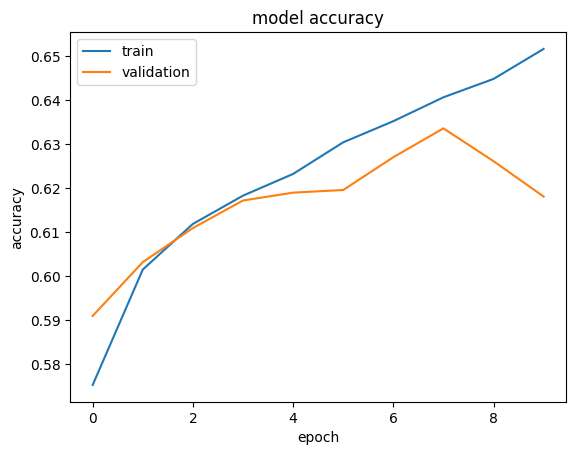

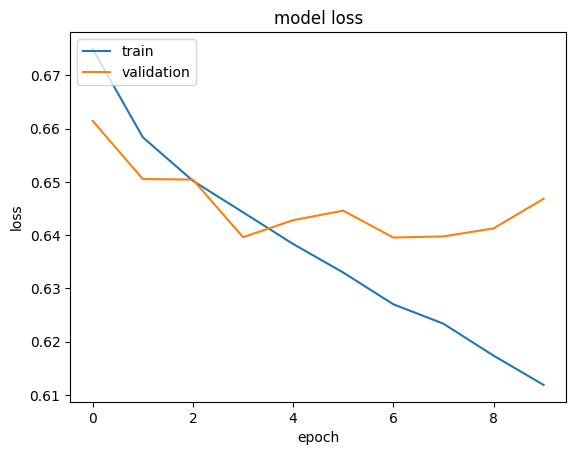

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import classification_report


In [23]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.62      0.63      0.62      8218
           1       0.63      0.61      0.62      8277

    accuracy                           0.62     16495
   macro avg       0.62      0.62      0.62     16495
weighted avg       0.62      0.62      0.62     16495



# # # **inception_module**

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model


In [25]:
def inception_module(x, filters):
    branch_1x1 = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
    
    branch_3x3 = Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
    
    branch_5x5 = Conv1D(filters, kernel_size=5, padding='same', activation='relu')(x)
    
    branch_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    branch_pool = Conv1D(filters, kernel_size=1, padding='same', activation='relu')(branch_pool)
    
    concat = Concatenate()([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return concat


In [26]:
def build_inception_text(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv1D(32, kernel_size=3, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    x = inception_module(x, filters=32)
    x = inception_module(x, filters=64)
    
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, filters=128)
    x = inception_module(x, filters=256)
    
    x = GlobalAveragePooling1D()(x)
    
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='sigmoid')(x)
    

    model = Model(input_layer, output_layer)
    return model


In [27]:
 model = build_inception_text(X_train[0].shape, 1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 32)    │      9,632 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 15, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 15, 32)    │          0 │ max_pooling1d_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 15, 32)    │      1,056 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 15, 32)    │      3,104 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 15, 32)    │      5,152 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 15, 32)    │      1,056 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 15, 128)   │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 15, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 15, 64)    │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 15, 64)    │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 15, 64)    │     41,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 15, 64)    │      8,256 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 15, 256)   │          0 │ conv1d_6[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 8, 256)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 8, 256)    │          0 │ max_pooling1d_4[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 8, 128)    │     32,896 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 8, 128)    │     98,432 │ max_pooling1d_4[

 Total params: 1,873,441 (7.15 MB)

 Trainable params: 1,873,441 (7.15 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, shuffle=True)


Epoch 1/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5621 - loss: 0.6845 - val_accuracy: 0.6017 - val_loss: 0.6538
Epoch 2/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6029 - loss: 0.6541 - val_accuracy: 0.6169 - val_loss: 0.6416
Epoch 3/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6151 - loss: 0.6442 - val_accuracy: 0.6268 - val_loss: 0.6364
Epoch 4/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6271 - loss: 0.6339 - val_accuracy: 0.6312 - val_loss: 0.6348
Epoch 5/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6331 - loss: 0.6300 - val_accuracy: 0.6378 - val_loss: 0.6335
Epoch 6/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6386 - loss: 0.6234 - val_accuracy: 0.6396 - val_loss: 0.6277
Epoch 7/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6415 - loss: 0.6206 - val_accuracy: 0.6333 - val_loss: 0.6340
Epoch 8/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6465 - loss: 0.6146 - val_accuracy: 

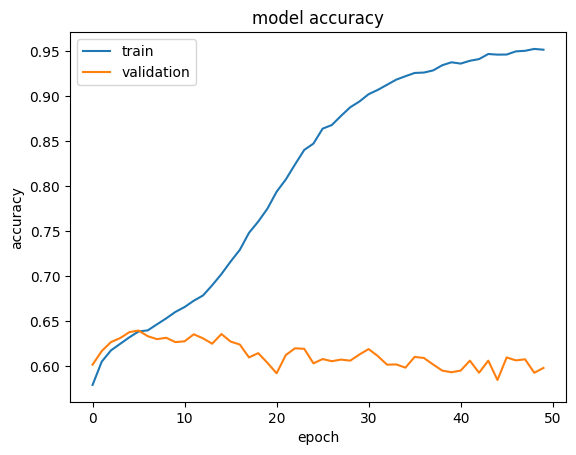

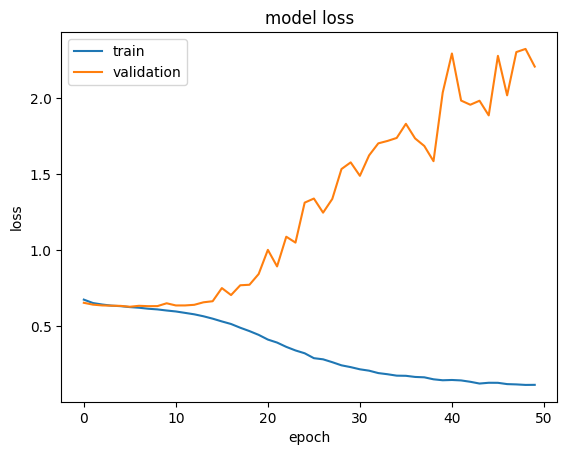

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))

516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      8218
           1       0.60      0.60      0.60      8277

    accuracy                           0.60     16495
   macro avg       0.60      0.60      0.60     16495
weighted avg       0.60      0.60      0.60     16495



# # # **regularized_dropout_inception_model**

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 30, 32)    │      9,632 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 15, 32)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 32)    │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 15, 32)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 15, 32)    │      1,056 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 15, 32)    │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 15, 32)    │      5,152 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 15, 32)    │      1,056 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 15, 128)   │          0 │ conv1d_19[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_20[0][0],  │
│                     │                   │            │ conv1d_21[0][0],  │
│                     │                   │            │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 15, 128)   │          0 │ concatenate_4[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 15, 64)    │      8,256 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 15, 64)    │     24,640 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 15, 64)    │     41,024 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 15, 64)    │      8,256 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 15, 256)   │          0 │ conv1d_23[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_24[0][0],  │
│                     │                   │            │ conv1d_25[0][0],  │
│                     │                   │            │ conv1d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 256)   │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 8, 256)    │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 8, 256)    │          0 │ max_pooling1d_10… │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 1,873,441 (7.15 MB)

 Trainable params: 1,873,441 (7.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.5552 - loss: 0.9643 - val_accuracy: 0.5751 - val_loss: 0.6866
Epoch 2/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5795 - loss: 0.6853 - val_accuracy: 0.5903 - val_loss: 0.6726
Epoch 3/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5812 - loss: 0.6792 - val_accuracy: 0.6002 - val_loss: 0.6659
Epoch 4/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5776 - loss: 0.6819 - val_accuracy: 0.6112 - val_loss: 0.6648
Epoch 5/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5969 - loss: 0.6693 - val_accuracy: 0.6187 - val_loss: 0.6603
Epoch 6/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5980 - loss: 0.6686 - val_accuracy: 0.6160 - val_loss: 0.6551
Epoch 7/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6023 - loss: 0.6701 - val_accuracy: 0.6169 - val_loss: 0.6555
Epoch 8/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6048 - loss: 0.6675 - val_accuracy: 

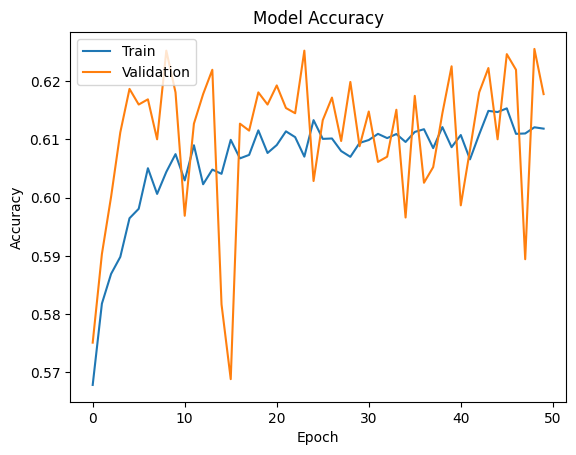

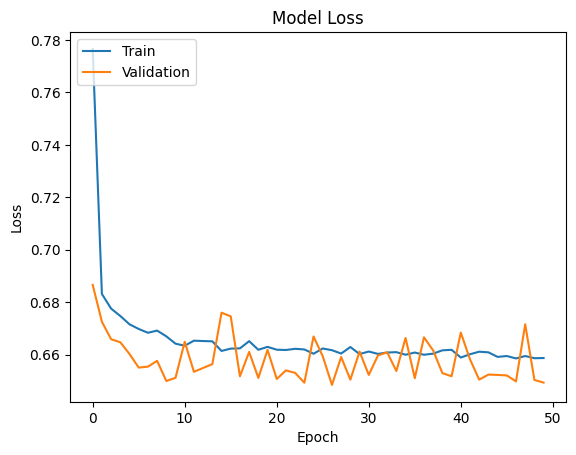

516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      8218
           1       0.64      0.57      0.60      8277

    accuracy                           0.62     16495
   macro avg       0.62      0.62      0.62     16495
weighted avg       0.62      0.62      0.62     16495



In [31]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, Input, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.regularizers as regularizers

def build_regularized_dropout_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_layer)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    x = Dropout(0.2)(x)

    x = inception_module(x, filters=32)
    x = inception_module(x, filters=64)
    x = Dropout(0.2)(x)

    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, filters=128)
    x = inception_module(x, filters=256)
    x = Dropout(0.2)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='sigmoid')(x)

    model = Model(input_layer, output_layer)
    return model

model = build_regularized_dropout_model(X_train[0].shape, 1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, shuffle=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model.
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))


# # # **INCEPTION_LearningRateScheduler**

Epoch 1/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.5359 - loss: 0.9171 - val_accuracy: 0.5646 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 2/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5755 - loss: 0.6827 - val_accuracy: 0.5852 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 3/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5835 - loss: 0.6787 - val_accuracy: 0.6088 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 4/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5972 - loss: 0.6752 - val_accuracy: 0.6088 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 5/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6001 - loss: 0.6719 - val_accuracy: 0.6112 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 6/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6040 - loss: 0.6658 - val_accuracy: 0.5912 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 7/50
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6009 - loss: 0.6675 

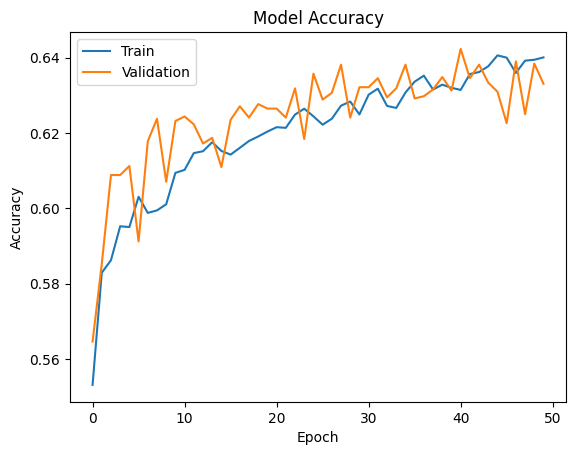

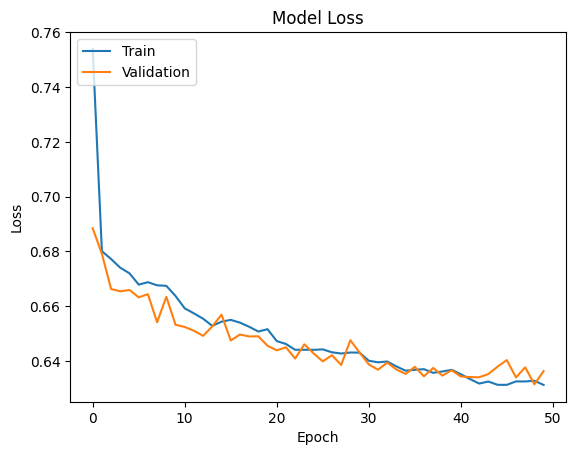

516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      8218
           1       0.66      0.55      0.60      8277

    accuracy                           0.63     16495
   macro avg       0.64      0.64      0.63     16495
weighted avg       0.64      0.63      0.63     16495



In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

model = build_regularized_dropout_model(X_train[0].shape, 1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [LearningRateScheduler(lr_schedule)]

# Train the regularized model with dropout and learning rate schedule
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, shuffle=True, callbacks=callbacks)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model.
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test , y_pred))


# # # **INCEPTION_EmbedingLayer**

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 30, 100)   │  1,000,000 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_222 (Conv1D) │ (None, 30, 32)    │      9,632 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_79    │ (None, 15, 32)    │          0 │ conv1d_222[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_80    │ (None, 15, 32)    │          0 │ max_pooling1d_79… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_223 (Conv1D) │ (None, 15, 32)    │      1,056 │ max_pooling1d_79… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_224 (Conv1D) │ (None, 15, 32)    │      3,104 │ max_pooling1d_79… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_225 (Conv1D) │ (None, 15, 32)    │      5,152 │ max_pooling1d_79… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_226 (Conv1D) │ (None, 15, 32)    │      1,056 │ max_pooling1d_80… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 15, 128)   │          0 │ conv1d_223[0][0], │
│ (Concatenate)       │                   │            │ conv1d_224[0][0], │
│                     │                   │            │ conv1d_225[0][0], │
│                     │                   │            │ conv1d_226[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_81    │ (None, 15, 128)   │          0 │ concatenate_52[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_227 (Conv1D) │ (None, 15, 64)    │      8,256 │ concatenate_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_228 (Conv1D) │ (None, 15, 64)    │     24,640 │ concatenate_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_229 (Conv1D) │ (None, 15, 64)    │     41,024 │ concatenate_52[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_230 (Conv1D) │ (None, 15, 64)    │      8,256 │ max_pooling1d_81… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_53      │ (None, 15, 256)   │          0 │ conv1d_227[0][0], │
│ (Concatenate)       │                   │            │ conv1d_228[0][0], │
│                     │                   │            │ conv1d_229[0][0], │
│                     │                   │            │ conv1d_230[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_82    │ (None, 8, 256)    │          0 │ concatenate_53[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_83    │ (None, 8, 256)    │          0 │ max_pooling1d_82… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,873,441 (10.96 MB)

 Trainable params: 2,873,441 (10.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6223 - loss: 0.6962 - val_accuracy: 0.7342 - val_loss: 0.5300
Epoch 2/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7982 - loss: 0.4441 - val_accuracy: 0.7363 - val_loss: 0.5692
Epoch 3/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8560 - loss: 0.3494 - val_accuracy: 0.7226 - val_loss: 0.6220
Epoch 4/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8949 - loss: 0.2696 - val_accuracy: 0.6987 - val_loss: 0.7100
Epoch 5/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9259 - loss: 0.2064 - val_accuracy: 0.6951 - val_loss: 0.8769
Epoch 6/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9452 - loss: 0.1631 - val_accuracy: 0.6948 - val_loss: 1.1750
Epoch 7/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9553 - loss: 0.1314 - val_accuracy: 0.6981 - val_loss: 1.3112
Epoch 8/20
942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9626 - loss: 0.1135 - val_accuracy: 

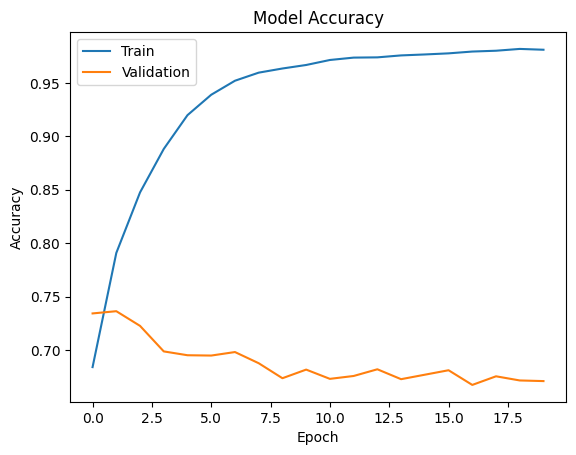

516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      8218
           1       0.67      0.69      0.68      8277

    accuracy                           0.68     16495
   macro avg       0.68      0.68      0.68     16495
weighted avg       0.68      0.68      0.68     16495



In [43]:
from tensorflow.keras.layers import Dropout, Input, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, Dense
import tensorflow.keras.regularizers as regularizers

def build_inception_text_with_regularization(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Embedding(max_words, embedding_dim, input_length=max_sequence_length)(input_layer)

    x = Conv1D(32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0045))(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    #x = Dropout(0.2)(x)

    x = inception_module(x, filters=32)
    x = inception_module(x, filters=64)
    #x = Dropout(0.2)(x)

    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, filters=128)
    x = inception_module(x, filters=256)
    #x = Dropout(0.2)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    #x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='sigmoid')(x)

    model = Model(input_layer, output_layer)
    return model

model = build_inception_text_with_regularization((max_sequence_length,), 1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, shuffle=True)

# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred))
